*Feature selection*
- 주어진 Feature 중, 최적의 조합을 찾는 방식

In [1]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Waeing
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
    
    
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#matplotlib 한글깨짐 지원
import platform
from matplotlib import font_manager, rc
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

- 데이터 불러오기

In [2]:
# 데이터 불러오기
path = './datasets/titanic/'
train = pd.read_csv(path+'train.csv', index_col='PassengerId').iloc[:,1:] # `PassengerId` 열을 인덱스 열로 지정
train_y = pd.read_csv(path+'train.csv', index_col='PassengerId').iloc[:,0] # `PassengerId` 열을 인덱스 열로 지정

test = pd.read_csv(path+'test.csv', index_col='PassengerId')

train

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
# 대략적인 데이터 확인 -> 결측치가 환불금액만 있음
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


- 간단한 전처리

In [4]:
# encoder 함수 지정
def encoder(data, kind):
    # 범주형 변수와 수치형 변수를 분리
    cat_features = data.select_dtypes(include=['object']).columns.to_list()
    num_features = data.select_dtypes(exclude='object').columns.to_list() 
    if kind == 'onehot':
        # 원핫인코딩
        data_cat = pd.get_dummies(data[cat_features])
        data = pd.concat([data,data_cat],axis=1).drop(columns=[f for f in cat_features])
        return data
    elif kind == 'label':
        # 라벨인코딩
        for c in cat_features:
            data[c]=pd.Categorical(data[c]).codes
        return data
    else:
        print('choose "onehot"or "label"')
# 인코딩
train = encoder(train, 'label')
test = encoder(test, 'label')

In [5]:
# 간단한 결측값 처리
## train
train['Age'] = train['Age'].fillna(train['Age'].mode()[0])
## test
test['Age'] = test['Age'].fillna(test['Age'].mode()[0])
test['Fare'] = test['Fare'].fillna(test['Fare'].mode()[0])

In [6]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train, train_y, test_size=0.2, random_state=0)

- 모든 피처를 사용하여 기본 모델의 성능을 확인

In [7]:
# 모델 선언
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

# fitting
random_forest.fit(x_train, y_train)

# 예측값
y_pred = random_forest.predict(x_valid)

# 확인
print(f'random_forest: {accuracy_score(y_valid, y_pred)}')

random_forest: 0.8603351955307262


## SelectPercentile
- 전체 데이터를 기준으로 하여 얼마만큼의 비율로 피쳐를 사용할지 결정

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 75.72it/s]


(1, 0.7865261499064315)


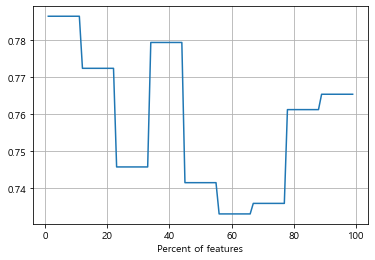

In [8]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = DecisionTreeClassifier(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(1,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(x_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='accuracy', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [9]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(train, train_y)
train_percentile = fs.transform(train)
test_percentile = fs.transform(test)

print(train_percentile.shape)

(891, 1)


- 검증 데이터를 사용하여 점수 확인

In [10]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train_percentile, train_y, test_size=0.2, random_state=0)

In [11]:
# 모델 선언
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
# fitting
random_forest.fit(x_train, y_train)
# 예측값
y_pred = random_forest.predict(x_valid)

# 확인
print(f'random_forest: {accuracy_score(y_valid, y_pred)}')

random_forest: 0.7877094972067039


## SelectFromModel
- Feature importance에 기반을 두고 thereshold 값에 따른 방식
- threhold의 default는 mean임

> 모델기반 Feature Selection
>> - 지도 학습 머신러닝 모델을 사용하여 특성의 중요도를 평가해서 가장 중요한 특성들만 선택
>> - 특성 선택에 사용하는 지도 학습 모델은 각 특성의 중요도가 담겨 있는 feature_importances_ 속성을 제공

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# rf모델을 사용하여 피처를 선택
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0), threshold="median") # threshold: 임계치, 중요도가 이 값보다 큰 특성을 선택 / 숫자로도 지정 가능
select.fit(train, train_y)

X_train_l1 = select.transform(train)

# 최종적으로 줄어든 피처의 갯수 확인
print("X_train_l1.shape : {}".format(X_train_l1.shape))

X_train_l1.shape : (891, 5)


- 검증 데이터를 사용하여 점수 확인

In [13]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(X_train_l1, train_y, test_size=0.2, random_state=0)

In [14]:
# 모델 선언
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
# fitting
random_forest.fit(x_train, y_train)
# 예측값
y_pred = random_forest.predict(x_valid)

# 확인
print(f'random_forest: {accuracy_score(y_valid, y_pred)}')

random_forest: 0.8491620111731844


## RFE(Recursive Feature Elimination)
- 모든 특성으로 시작해서 모델을 만들고 특성 중요도(feature importance)가 가장 낮은 특성을 제거
- 이후 제거한 특성을 빼고 나머지 특성 전체로 새로운 모델생성
- 위의 방법을 지정한 특성 개수가 남을 때까지 반복(recursive)
- 후진제거법

> 단점
> - 사용자가 직접 특성의 갯수를 선정해줘야 한다는 단점이 있음
> - 데이터의 크기가 크면 시간이 오래 걸리기 때문에 크기가 작은 데이터셋에 사용하기에 적합함

In [15]:
from sklearn.feature_selection import RFE

In [16]:
# Selecting the Best important features according to RandomForestClassifier
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=0), n_features_to_select = 5, step = 1)
rfe_selector.fit(train, train_y)

# 선택된 특성들
train.columns[rfe_selector.get_support()]

Index(['Name', 'Sex', 'Age', 'Ticket', 'Fare'], dtype='object')

In [17]:
# 선택된 특성들을 데이터로
train_RFE = train[list(train.columns[rfe_selector.get_support()])]

- 검증 데이터를 사용하여 점수 확인

In [18]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train_RFE, train_y, test_size=0.2, random_state=0)

In [19]:
# 모델 선언
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
# fitting
random_forest.fit(x_train, y_train)
# 예측값
y_pred = random_forest.predict(x_valid)

# 확인
print(f'random_forest: {accuracy_score(y_valid, y_pred)}')

random_forest: 0.8491620111731844


## RFECV(Recursive Feature Elimination with Cross Validation)
- RFE의 가장 큰 단점은 사용자가 직접 몇개의 특성을 남길지 지정해야한다는 점이었는데, 
- RFECV는 K-fold cross validation을 사용하여 각기 다른 결과를 도출함
- 이렇게 도출된 결과들의 평균으로 최종 특성을 선택

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [21]:
# 모델 선언
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

min_features_to_select = 1  # 고려되어야할 최소 특성의 갯수
rfecv = RFECV(
    estimator=random_forest,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(train, train_y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 7


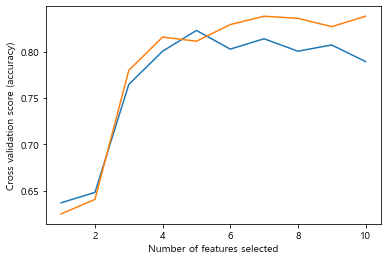

In [22]:
# 선택된 특성과 score를 그래프로 표현
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [23]:
# 선택된 특성들을 데이터로
train_RFECV = train[list(train.columns[rfecv.get_support()])]

- 검증 데이터를 사용하여 점수 확인

In [24]:
# 데이터를 학습과 검증으로 분리
x_train, x_valid, y_train, y_valid = train_test_split(train_RFECV, train_y, test_size=0.2, random_state=0)

In [25]:
# 모델 선언
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
# fitting
random_forest.fit(x_train, y_train)
# 예측값
y_pred = random_forest.predict(x_valid)

# 확인
print(f'random_forest: {accuracy_score(y_valid, y_pred)}')

random_forest: 0.8547486033519553


# END